In [ ]:
!pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
import numpy as np
import plotly.express as px
from PIL import Image

imagen = Image.open("/content/suiza_1.jpg")
fig = px.imshow(imagen)
fig.show()
pixel = imagen.load()
print(pixel[0,0])

(226, 224, 237)


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
img = imagen.resize((50,50), Image.LANCZOS)

imagen_mat = np.array(list(img.getdata(band=0)), int)
list_1 = imagen_mat.tolist()  #MATRIZ en forma de lista
print(list_1)

imagen_mat.shape = (img.size[0], img.size[1])
#print(imagen_mat)

print(imagen_mat.shape)

[201, 181, 179, 189, 153, 188, 180, 226, 205, 172, 168, 204, 218, 195, 198, 208, 211, 217, 198, 223, 243, 249, 176, 90, 92, 197, 204, 207, 229, 233, 209, 215, 205, 213, 243, 225, 218, 206, 141, 147, 165, 157, 172, 250, 238, 242, 241, 239, 243, 245, 219, 212, 151, 193, 224, 241, 227, 217, 209, 187, 185, 184, 205, 201, 168, 222, 241, 240, 224, 223, 199, 143, 99, 109, 181, 189, 194, 214, 226, 237, 209, 218, 216, 218, 232, 245, 221, 171, 140, 129, 135, 147, 136, 206, 241, 234, 237, 241, 248, 250, 219, 226, 204, 190, 217, 209, 216, 193, 195, 195, 209, 138, 151, 188, 178, 225, 221, 242, 234, 208, 223, 169, 63, 86, 109, 194, 213, 232, 240, 231, 209, 201, 223, 222, 224, 244, 230, 120, 46, 109, 114, 134, 141, 137, 229, 235, 235, 245, 251, 252, 217, 218, 200, 206, 202, 209, 203, 169, 179, 234, 214, 106, 57, 186, 225, 201, 205, 226, 231, 190, 225, 185, 92, 75, 76, 240, 234, 238, 234, 213, 219, 204, 234, 217, 228, 238, 217, 151, 34, 25, 32, 61, 99, 124, 167, 241, 239, 252, 230, 245, 195, 193, 186,

In [ ]:
%%cuda
#include <cassert>
#include <cstdlib>
#include <iostream>

// 7 x 7 convolutional mask
#define MASK_DIM 7

// Amount the the matrix will hang over the matrix
#define MASK_OFFSET (MASK_DIM / 2)

// Allocate mask in constant memory
__constant__ int mask[7 * 7];


// 2d conv kernel
//  matrix: colocamos la matriz de la imagen
//  result: matriz rsultado
//  N:      Dimensiones de la matriz (elegimos una cuadrada)
__global__ void conv_2d(int *matrix, int *result, int N) {
  // pisicones de hilos
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  // iniciando inices de posicion
  int start_r = row - MASK_OFFSET;
  int start_c = col - MASK_OFFSET;

  int temp = 0;

  // Iterar ROWS
  for (int i = 0; i < MASK_DIM; i++) {
    // Itrar Columns
    for (int j = 0; j < MASK_DIM; j++) {
      // chekear el rango de las rows
      if ((start_r + i) >= 0 && (start_r + i) < N) {
        // chekear el rango de las cols
        if ((start_c + j) >= 0 && (start_c + j) < N) {
          // resultado acumulado
          temp += matrix[(start_r + i) * N + (start_c + j)] *
                  mask[i * MASK_DIM + j];
        }
      }
    }
  }

  // escribir el resultado
  result[row * N + col] = temp;
}

// Inicializa la matriz
//  m : Puntero a la matriz
//  n : dimension de la matriz (cuadrado)

void init_matrix(int *m, int n) {
  for (int i = 0; i < n; i++) {
    for (int j = 0; j < n; j++) {
      m[n * i + j] = rand() % 100;
    }
  }
}

// Ver el resutlado en cpu
//  m:      MAtriz
//  mask
//  result: resultado extraído del gpu
//  N:      dimension de la matriz
void verify_result(int *m, int *mask, int *result, int N) {
  int temp;

  int offset_r;
  int offset_c;

  // Iterar rows
  for (int i = 0; i < N; i++) {
    // Iterar cols
    for (int j = 0; j < N; j++) {
      temp = 0;

      // iterar en cada row la mascara
      for (int k = 0; k < MASK_DIM; k++) {
        offset_r = i - MASK_OFFSET + k;
        //std::cout << "offset_row";
        //std::cout << offset_r;
        // iterar en cada col la mascara
        for (int l = 0; l < MASK_DIM; l++) {
          // actualizar el offset
          offset_c = j - MASK_OFFSET + l;
          //std::cout << "offset_column";
          //std::cout << offset_c;
          // No debernos salirnos de la matriz
          if (offset_r >= 0 && offset_r < N) {
            if (offset_c >= 0 && offset_c < N) {
              // acumular los resultados
              temp += m[offset_r * N + offset_c] * mask[k * MASK_DIM + l];

              //std::cout << "temporal";
              //std::cout << temp;
            }
          }
        }
      }
      // crear un fail-log
      assert(result[i * N + j] == temp);
    }
  }
}

int main() {

  // Dimensiones de la matriz imagen
  const int rows_s = 50;
  const int cols_s = 50;
  const int size = rows_s * cols_s;

  // matriz imagen
  int h_A[size] = {201, 181, 179, 189, 153, 188, 180, 226, 205, 172, 168, 204, 218, 195, 198, 208, 211, 217, 198, 223, 243, 249, 176, 90, 92, 197, 204, 207, 229, 233, 209, 215, 205, 213, 243, 225, 218, 206, 141, 147, 165, 157, 172, 250, 238, 242, 241, 239, 243, 245, 219, 212, 151, 193, 224, 241, 227, 217, 209, 187, 185, 184, 205, 201, 168, 222, 241, 240, 224, 223, 199, 143, 99, 109, 181, 189, 194, 214, 226, 237, 209, 218, 216, 218, 232, 245, 221, 171, 140, 129, 135, 147, 136, 206, 241, 234, 237, 241, 248, 250, 219, 226, 204, 190, 217, 209, 216, 193, 195, 195, 209, 138, 151, 188, 178, 225, 221, 242, 234, 208, 223, 169, 63, 86, 109, 194, 213, 232, 240, 231, 209, 201, 223, 222, 224, 244, 230, 120, 46, 109, 114, 134, 141, 137, 229, 235, 235, 245, 251, 252, 217, 218, 200, 206, 202, 209, 203, 169, 179, 234, 214, 106, 57, 186, 225, 201, 205, 226, 231, 190, 225, 185, 92, 75, 76, 240, 234, 238, 234, 213, 219, 204, 234, 217, 228, 238, 217, 151, 34, 25, 32, 61, 99, 124, 167, 241, 239, 252, 230, 245, 195, 193, 186, 180, 175, 187, 185, 197, 219, 231, 218, 217, 52, 111, 214, 168, 205, 204, 219, 238, 227, 112, 111, 49, 99, 203, 169, 223, 243, 222, 229, 206, 220, 233, 223, 184, 145, 136, 53, 36, 46, 38, 30, 37, 41, 151, 254, 248, 121, 216, 181, 168, 184, 170, 141, 188, 156, 142, 191, 226, 213, 245, 173, 25, 152, 192, 184, 199, 184, 223, 179, 132, 220, 37, 120, 204, 145, 198, 234, 216, 220, 202, 218, 223, 217, 135, 106, 111, 38, 22, 10, 15, 38, 51, 51, 60, 248, 197, 54, 202, 177, 162, 132, 190, 211, 194, 223, 187, 178, 196, 178, 187, 222, 134, 35, 143, 165, 197, 166, 217, 141, 192, 192, 49, 141, 249, 244, 189, 191, 206, 233, 210, 231, 219, 145, 106, 123, 95, 94, 103, 90, 62, 10, 0, 40, 74, 172, 238, 178, 239, 79, 139, 156, 179, 197, 190, 197, 204, 185, 187, 203, 225, 221, 237, 128, 59, 163, 137, 206, 218, 136, 204, 188, 163, 171, 240, 244, 177, 196, 233, 232, 191, 185, 155, 109, 110, 95, 52, 71, 80, 102, 84, 57, 8, 13, 70, 100, 245, 199, 229, 42, 132, 221, 204, 175, 197, 204, 160, 207, 205, 236, 229, 223, 223, 223, 207, 230, 177, 163, 144, 200, 214, 191, 239, 227, 225, 226, 225, 210, 214, 211, 209, 132, 121, 109, 117, 65, 0, 66, 87, 77, 65, 100, 27, 11, 51, 73, 171, 147, 130, 152, 187, 195, 191, 148, 171, 210, 203, 231, 185, 191, 163, 181, 192, 204, 221, 237, 210, 220, 193, 233, 184, 160, 226, 224, 218, 219, 188, 197, 217, 205, 200, 185, 221, 189, 114, 91, 12, 35, 92, 87, 28, 60, 77, 13, 31, 77, 78, 153, 126, 175, 215, 118, 162, 185, 151, 173, 211, 176, 166, 138, 135, 177, 182, 171, 197, 226, 221, 189, 205, 200, 137, 60, 191, 221, 183, 190, 207, 230, 227, 225, 235, 250, 253, 197, 125, 128, 11, 75, 94, 70, 34, 43, 128, 36, 33, 64, 75, 154, 154, 178, 171, 69, 83, 218, 182, 174, 189, 208, 214, 200, 201, 206, 212, 224, 238, 197, 178, 119, 202, 218, 119, 44, 169, 185, 219, 226, 233, 232, 235, 222, 233, 233, 236, 193, 174, 153, 7, 105, 153, 112, 44, 54, 175, 71, 34, 43, 67, 110, 168, 172, 200, 164, 40, 118, 175, 221, 222, 194, 202, 229, 205, 225, 193, 167, 180, 225, 145, 141, 214, 166, 73, 123, 212, 126, 212, 237, 237, 219, 231, 203, 224, 213, 233, 234, 228, 156, 6, 88, 148, 133, 55, 27, 181, 133, 37, 23, 74, 80, 151, 114, 160, 183, 118, 34, 158, 199, 206, 201, 172, 203, 200, 239, 217, 202, 206, 187, 85, 213, 242, 173, 66, 126, 220, 143, 140, 221, 215, 240, 236, 226, 239, 234, 231, 238, 239, 171, 132, 107, 121, 159, 92, 32, 174, 182, 67, 21, 80, 67, 94, 177, 135, 144, 167, 94, 84, 199, 181, 193, 197, 179, 181, 191, 204, 196, 207, 84, 107, 122, 160, 98, 60, 87, 188, 206, 206, 213, 227, 213, 222, 230, 192, 180, 200, 235, 240, 203, 250, 195, 143, 145, 130, 90, 153, 202, 94, 41, 47, 58, 65, 173, 200, 153, 143, 151, 49, 178, 187, 158, 218, 204, 202, 208, 161, 196, 160, 124, 199, 94, 103, 95, 54, 114, 220, 220, 191, 185, 203, 175, 230, 237, 205, 196, 213, 235, 242, 234, 224, 249, 209, 115, 144, 103, 147, 216, 100, 26, 22, 32, 81, 106, 196, 215, 155, 121, 68, 101, 183, 132, 205, 234, 201, 190, 209, 135, 124, 219, 208, 230, 195, 101, 73, 106, 124, 106, 145, 183, 143, 75, 158, 228, 210, 161, 199, 237, 219, 233, 229, 230, 244, 171, 209, 142, 158, 227, 120, 20, 26, 20, 79, 40, 97, 123, 135, 138, 52, 33, 119, 164, 198, 206, 212, 203, 126, 117, 218, 216, 218, 206, 191, 45, 101, 189, 95, 110, 144, 168, 154, 137, 155, 208, 246, 135, 152, 237, 218, 208, 230, 200, 219, 226, 236, 190, 173, 222, 146, 40, 22, 25, 47, 33, 57, 136, 208, 224, 130, 31, 91, 147, 228, 193, 201, 133, 116, 199, 212, 185, 178, 177, 123, 31, 149, 209, 85, 138, 170, 168, 149, 211, 218, 177, 217, 186, 211, 243, 235, 222, 144, 173, 248, 237, 227, 233, 201, 225, 151, 50, 72, 27, 43, 151, 61, 56, 133, 201, 184, 182, 122, 162, 219, 207, 101, 127, 216, 221, 230, 209, 231, 218, 132, 75, 189, 138, 101, 167, 155, 37, 197, 222, 182, 234, 238, 236, 242, 237, 241, 227, 144, 157, 164, 212, 201, 223, 233, 233, 192, 111, 127, 35, 45, 214, 183, 68, 66, 138, 178, 222, 118, 171, 204, 130, 147, 217, 212, 190, 186, 234, 235, 183, 75, 72, 222, 158, 119, 114, 57, 47, 128, 116, 18, 177, 226, 193, 202, 216, 231, 236, 163, 150, 89, 74, 65, 138, 237, 237, 205, 155, 178, 79, 30, 180, 207, 167, 58, 132, 209, 217, 152, 141, 129, 165, 236, 220, 207, 208, 170, 251, 238, 146, 54, 86, 225, 237, 204, 168, 158, 66, 92, 94, 67, 196, 100, 37, 112, 123, 136, 161, 156, 184, 130, 83, 53, 91, 212, 235, 209, 189, 206, 141, 37, 156, 169, 194, 157, 147, 177, 201, 99, 89, 186, 242, 208, 214, 225, 241, 165, 232, 230, 84, 33, 110, 215, 213, 121, 129, 164, 80, 66, 119, 88, 227, 82, 19, 108, 99, 96, 42, 49, 144, 94, 104, 80, 106, 203, 223, 234, 236, 221, 183, 86, 205, 178, 179, 191, 179, 210, 182, 69, 90, 230, 213, 198, 222, 198, 231, 193, 200, 208, 25, 0, 145, 249, 142, 34, 51, 74, 45, 56, 128, 83, 241, 73, 41, 179, 167, 157, 53, 39, 114, 99, 72, 108, 102, 78, 125, 141, 167, 211, 189, 65, 195, 187, 156, 177, 208, 190, 124, 56, 43, 170, 209, 201, 215, 226, 237, 206, 225, 140, 65, 59, 205, 218, 62, 58, 76, 65, 45, 73, 119, 113, 254, 70, 28, 151, 168, 174, 61, 38, 158, 163, 135, 139, 106, 27, 103, 99, 54, 92, 205, 43, 189, 189, 183, 170, 213, 140, 55, 96, 47, 101, 227, 226, 220, 226, 234, 196, 234, 131, 109, 118, 212, 103, 56, 77, 77, 54, 58, 114, 88, 139, 255, 69, 33, 151, 138, 125, 67, 43, 133, 112, 116, 153, 118, 37, 167, 167, 68, 78, 216, 57, 184, 178, 193, 181, 139, 164, 154, 71, 72, 59, 202, 198, 216, 225, 222, 198, 206, 96, 52, 75, 138, 53, 105, 74, 57, 71, 70, 145, 139, 149, 255, 71, 35, 179, 179, 153, 67, 34, 118, 110, 91, 167, 117, 26, 150, 174, 78, 78, 218, 94, 189, 193, 180, 167, 116, 196, 201, 124, 65, 36, 149, 206, 209, 228, 225, 230, 192, 27, 16, 89, 119, 88, 73, 26, 63, 102, 75, 147, 151, 162, 255, 76, 33, 161, 178, 156, 72, 53, 133, 108, 104, 171, 85, 18, 147, 150, 81, 66, 224, 63, 184, 189, 165, 107, 170, 192, 170, 200, 100, 27, 122, 213, 202, 225, 231, 234, 177, 30, 40, 135, 162, 105, 74, 29, 76, 129, 52, 132, 191, 194, 255, 78, 38, 163, 153, 134, 76, 97, 155, 98, 97, 172, 121, 37, 174, 175, 84, 62, 225, 84, 166, 166, 119, 170, 179, 170, 136, 174, 171, 34, 104, 174, 202, 218, 199, 214, 98, 21, 70, 142, 188, 139, 59, 41, 99, 140, 64, 164, 215, 204, 255, 114, 73, 174, 148, 100, 37, 61, 147, 94, 99, 160, 132, 48, 152, 154, 99, 88, 229, 126, 127, 111, 151, 178, 181, 156, 89, 145, 195, 84, 75, 126, 201, 227, 229, 194, 42, 35, 110, 157, 178, 147, 81, 38, 101, 142, 132, 237, 205, 200, 255, 191, 136, 154, 160, 162, 111, 134, 164, 103, 99, 172, 132, 36, 157, 149, 83, 76, 231, 168, 103, 177, 170, 161, 197, 71, 67, 146, 196, 124, 61, 105, 198, 222, 236, 129, 26, 101, 146, 145, 171, 133, 63, 39, 87, 201, 223, 255, 186, 199, 254, 204, 107, 75, 74, 76, 171, 223, 160, 93, 83, 166, 182, 108, 149, 138, 67, 91, 238, 223, 134, 189, 184, 175, 110, 10, 44, 176, 187, 175, 71, 40, 98, 219, 175, 42, 51, 108, 145, 154, 179, 134, 76, 59, 152, 245, 247, 255, 207, 204, 255, 213, 151, 174, 177, 126, 174, 220, 163, 85, 66, 162, 200, 172, 84, 83, 58, 140, 248, 234, 117, 192, 182, 147, 22, 31, 116, 196, 182, 184, 122, 51, 69, 174, 68, 29, 81, 89, 131, 157, 169, 139, 84, 136, 234, 235, 224, 254, 192, 193, 241, 188, 137, 134, 153, 145, 164, 197, 170, 118, 118, 171, 198, 179, 93, 67, 39, 148, 252, 232, 154, 216, 146, 158, 72, 175, 222, 194, 178, 191, 118, 39, 111, 78, 43, 73, 109, 127, 174, 147, 165, 162, 104, 206, 248, 248, 228, 226, 165, 177, 223, 157, 130, 134, 126, 128, 129, 130, 122, 124, 125, 123, 129, 132, 134, 129, 82, 148, 249, 233, 195, 202, 152, 131, 90, 210, 206, 205, 185, 193, 95, 14, 50, 28, 45, 101, 110, 188, 203, 212, 244, 220, 145, 203, 248, 228, 207, 231, 188, 151, 202, 160, 95, 89, 107, 116, 132, 145, 155, 141, 137, 142, 141, 131, 132, 139, 122, 145, 238, 231, 199, 177, 118, 95, 173, 218, 213, 210, 199, 196, 145, 47, 27, 62, 75, 107, 138, 192, 163, 234, 242, 223, 146, 201, 221, 222, 220, 215, 193, 193, 174, 166, 84, 56, 59, 48, 80, 97, 111, 78, 73, 59, 55, 62, 76, 86, 123, 200, 205, 191, 193, 171, 27, 105, 221, 193, 218, 204, 193, 201, 164, 88, 61, 33, 85, 107, 182, 200, 166, 191, 190, 163, 126, 194, 233, 233, 199, 141, 152, 165, 207, 134, 89, 94, 99, 93, 115, 122, 129, 113, 96, 58, 34, 22, 40, 43, 76, 187, 208, 182, 178, 109, 43, 165, 224, 218, 202, 189, 191, 189, 105, 44, 65, 32, 60, 135, 163, 227, 168, 144, 160, 138, 118, 211, 220, 222, 207, 160, 137, 118, 162, 34, 15, 68, 88, 86, 102, 121, 151, 145, 114, 67, 44, 24, 72, 94, 107, 170, 203, 163, 173, 77, 41, 212, 217, 214, 209, 202, 193, 165, 67, 24, 42, 52, 97, 181, 173, 220, 203, 123, 102, 121, 143, 176, 144, 201, 180, 176, 151, 142, 157, 169, 76, 100, 117, 125, 92, 95, 159, 141, 83, 79, 63, 1, 46, 70, 61, 35, 135, 156, 107, 34, 53, 213, 204, 211, 212, 159, 191, 165, 77, 48, 81, 71, 104, 204, 209, 207, 215, 170, 131, 169, 148, 114, 178, 185, 148, 129, 190, 191, 185, 171, 88, 162, 171, 170, 95, 78, 149, 108, 61, 89, 80, 3, 84, 116, 98, 28, 121, 161, 66, 23, 140, 210, 164, 177, 220, 168, 166, 216, 88, 71, 99, 78, 91, 229, 238, 232, 244, 178, 129, 166, 151, 138, 177, 133, 131, 118, 150, 143, 168, 119, 36, 117, 101, 115, 97, 67, 123, 158, 141, 132, 90, 6, 106, 159, 135, 32, 109, 160, 53, 61, 171, 213, 191, 165, 222, 158, 153, 193, 100, 80, 96, 93, 123, 218, 217, 197, 209, 176, 134, 167, 142, 120, 127, 103, 127, 96, 159, 150, 177, 95, 113, 137, 119, 131, 105, 51, 82, 74, 53, 123, 88, 0, 65, 97, 110, 37, 96, 177, 90, 102, 176, 209, 203, 169, 221, 156, 111, 192, 95, 78, 93, 79, 139, 214, 211, 218, 219, 171, 130, 167, 140, 134, 133, 64, 150, 91, 108, 132, 158, 41, 95, 118, 128, 123, 107, 59, 93, 63, 32, 125, 88, 1, 72, 108, 120, 38, 89, 184, 96, 151, 187, 198, 200, 213, 205, 172, 92, 179, 141, 91, 92, 66, 107, 162, 172, 214, 195, 181, 107, 160, 133, 104, 146, 62, 155, 80, 126, 143, 169, 30, 36, 98, 116, 119, 68, 66, 131, 51, 43, 128, 126, 4, 67, 112, 121, 43, 85, 182, 103, 146, 169, 132, 94, 90, 96, 133, 122, 167, 160, 99, 55, 65, 85, 143, 161, 200, 154, 161, 144, 190, 111, 88, 155, 52, 139, 98, 159, 172, 176, 33, 63, 82, 116, 128, 76, 63, 144, 45, 48, 129, 134, 6, 54, 97, 113, 60, 79, 183, 85, 124, 143, 101, 99, 123, 84, 104, 130, 83, 99, 66, 26, 54, 123, 145, 163, 196, 132, 165, 183, 191, 99, 114, 151, 75, 150, 124, 114, 141, 196, 77, 47, 56, 92, 89, 60, 65, 126, 46, 50, 121, 138, 1, 66, 137, 169, 114, 73, 191, 72, 97, 105, 101, 123, 126, 77, 127, 79, 49, 62, 64, 13, 25, 135, 160, 159, 145, 130, 160, 166, 166, 91, 104, 165, 80, 164, 142, 88, 137, 158, 88, 59, 157, 171, 171, 73, 45, 121, 50, 38, 119, 141, 8, 96, 169, 179, 103, 72, 194, 114, 89, 43, 57, 98, 122, 82, 105, 43, 53, 53, 66, 33, 39, 93, 106, 112, 141, 110, 165, 168, 161, 100, 119, 191, 123, 100, 106, 87, 128, 155, 141, 123, 115, 116, 119, 126, 139, 126, 118, 126, 137, 154, 115, 118, 114, 154, 127, 144, 194, 125, 104, 52, 51, 54, 71, 95, 86, 64, 36, 54, 75, 57, 59, 93, 94, 92, 130, 94, 150, 161, 133, 118, 119, 194, 141, 65, 114, 84, 126, 172, 185, 178, 180, 182, 175, 166, 176, 144, 176, 190, 164, 167, 210, 179, 173, 175, 174, 203, 183};

  int N = 50; //32

  // tamaño de la matriz en Bytes
  size_t bytes_n = rows_s * cols_s * sizeof(int);

  int *matrix = h_A; // una matriz cuadrada declarada arriba
  int *result = new int[N * N];


  // Size of the mask in bytes
  size_t bytes_m = MASK_DIM * MASK_DIM * sizeof(int);

  // localizar la mask e inicializar
  int *h_mask = new int[MASK_DIM * MASK_DIM];
  init_matrix(h_mask, MASK_DIM);

  // Device memory
  int *d_matrix;
  int *d_result;
  cudaMalloc(&d_matrix, bytes_n);
  cudaMalloc(&d_result, bytes_n);

  // copiarmos al devide
  cudaMemcpy(d_matrix, matrix, bytes_n, cudaMemcpyHostToDevice);
  cudaMemcpyToSymbol(mask, h_mask, bytes_m);

  // calcuilamos las dimensiones
  int THREADS = 25; // El numero de threads debe ser la mitad de las rows/cols
  int BLOCKS = (N + THREADS - 1) / THREADS;

  // lanzamos los argumentos
  dim3 block_dim(THREADS, THREADS);
  dim3 grid_dim(BLOCKS, BLOCKS);

  // llamamos a la convolucion
  conv_2d<<<grid_dim, block_dim>>>(d_matrix, d_result, N);

  // copiamos el resultado al CPU
  cudaMemcpy(result, d_result, bytes_n, cudaMemcpyDeviceToHost);

  verify_result(matrix, h_mask, result, N);

  std::cout << "COMPLETADO";
  std::cout << "\n";

  // MATRIZ RESULTADO
  for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            std::cout << result[i * N + j] << " ";
        }
        std::cout << std::endl;
    };

  // liberar memoria
  delete[] matrix;
  delete[] result;
  delete[] h_mask;

  cudaFree(d_matrix);
  cudaFree(d_result);

  return 0;
}

primer for
COMPLETED SUCCESSFULLY!
133504 176562 223659 269423 260618 258809 257360 261282 256911 253087 246696 237027 241898 245098 260338 269262 273208 279483 277061 265157 244224 227333 223971 211460 210851 213816 240813 264211 281428 287020 287794 293256 291619 289549 279392 259731 243655 225551 205719 176003 164785 181909 206294 232248 252996 276107 304971 269922 231723 185094 
160926 209152 258342 318172 312428 309259 320543 323260 312699 295124 301355 294127 294798 286161 287616 316031 326697 336708 337169 318238 287411 261850 255781 255489 255672 249934 282029 315980 342490 350776 349962 353354 352232 349303 332083 300215 277083 253928 236347 204946 177181 179757 210848 238188 273561 304139 342270 313915 278547 212771 
204839 250155 308824 386194 385336 378558 386638 389550 388095 365747 375452 377661 368680 364285 350485 374668 400774 415323 415369 392419 351720 329467 317757 332480 315644 316258 344015 384878 421599 431218 437312 442166 436617 426147 407603 368292 326939 2942

In [ ]:
string = """13134 19260 22328 24601 28807 34351 37076 49472 46114 58609 81018 89499 107854 106818 103377 104073 111009 85621 64396 26298 3900 20661 39688 55275 60854 69213 86131 93399 88601 67458 51639 40689
30346 43334 55981 65326 76369 84957 73628 70719 79748 101618 133848 127356 134159 131050 131517 127112 116652 80942 64617 27087 6914 31093 59437 74269 78033 92079 103588 123407 110019 85859 65593 51462
62131 81090 92040 109060 129404 155737 145072 116278 113075 133798 179364 189257 183364 182626 167616 157342 150130 103243 85983 46917 24894 50475 74471 94418 101905 120518 130420 150042 131050 104644 79954 62878
104711 140642 148376 163252 175788 211462 224441 189429 166954 173019 218344 243060 241798 213958 202330 199917 189417 138250 113403 78123 61399 75561 89930 114105 124631 146376 158488 177838 154796 120924 99833 79014
130734 177321 207559 232495 233420 259875 274342 252407 221067 219112 243185 255613 229786 194419 190506 191745 169970 122321 105521 87289 83300 101425 115608 130502 135448 149026 169317 185354 155635 117052 101394 80967
156872 202389 247788 295907 302230 317995 329025 296972 270374 270807 276841 249590 209509 169291 164752 156677 144965 112951 100308 95111 101378 124206 153376 153055 157371 160210 185171 190821 163067 124058 102937 82814
189254 238562 288610 351275 361900 385976 386414 339059 311835 311156 292929 252495 203197 165703 158084 137200 128310 113730 110933 109478 120846 147776 157715 160253 163536 172798 197304 192967 153556 121144 102839 89415
201313 264628 312043 368357 385440 409735 414622 368661 334178 310090 292115 254667 216950 173580 169541 145696 137331 126761 131985 135322 158740 166066 167791 152822 145367 165273 182596 176805 138320 107149 96705 84823
206177 271092 322062 377584 389460 396927 402212 377297 328066 296144 267607 232573 195323 163899 154885 149625 157093 148449 167150 184582 189763 185935 186519 164760 149716 149768 152384 149696 129921 99857 97567 82748
186172 245737 306097 374225 386899 390949 387506 368057 322768 286144 247252 202633 166401 141278 142693 153290 164698 175559 198931 202105 208584 195264 197601 179112 162800 142088 143297 140907 134875 107998 105607 87689
155041 193204 244359 310621 338237 351290 348118 331135 297916 266273 227993 182717 145063 137841 142086 147020 157896 180439 214759 215071 203563 193824 193901 179720 167594 148516 148107 151749 151567 126420 109687 92215
125443 157816 198106 248515 278437 293163 288446 271365 241660 221979 192802 148385 124252 124913 123715 127327 138862 171341 209317 213915 207142 196973 192711 181713 170741 164744 166932 168870 167603 143538 124306 109768
91838 128092 156117 200954 219255 245561 247443 228898 201643 174772 153105 121548 104939 104597 106808 118803 142076 173527 200532 205242 196493 188863 182740 183301 182964 174381 174612 168510 175126 156961 141840 120932
69749 100925 128360 160069 172688 198583 207264 197628 177371 150806 128190 107159 93197 102302 117808 145625 173675 193323 218121 217247 214102 208530 199524 193888 192152 171475 166438 163162 182883 159365 136605 108476
55651 85756 110652 138060 152744 175615 190702 180056 155564 141130 116886 114565 102020 115859 141844 176073 207592 228451 247823 253032 254912 236582 227854 206951 204982 180188 172634 175335 199799 165540 133605 103372
44757 72396 96993 128288 143543 166522 175355 160243 137831 126918 113739 117766 117738 133788 155532 183382 209695 223141 249415 243942 239862 203990 201350 196641 206349 198418 187205 185793 197556 167734 144003 108472
57407 82424 97523 127379 143842 162529 159818 143757 124043 121217 114906 121439 127825 136068 151448 172699 187898 202361 209389 211523 202302 189965 190417 192059 207435 210220 192719 186351 183665 169651 143462 110607
69087 98134 119597 148850 151583 158815 160115 147434 141655 125076 114310 119659 130853 144525 166473 167822 178823 187918 184737 197689 191157 199535 198378 204666 216166 208971 195234 185994 187097 159985 130425 95295
70611 105491 130826 173878 169014 177199 173583 163102 149649 137664 122991 126521 139501 156552 178489 191863 195964 209958 197390 200258 196550 189738 193408 197575 208725 212431 197918 183048 174484 141786 107720 76538
82770 110820 144849 181153 180857 198651 197747 178111 160278 145664 135940 148881 155919 164148 187045 204073 230128 239936 226345 226477 221767 214572 206866 194069 210273 210740 187788 165780 154446 125636 103878 69931
88293 113248 142702 172275 187995 218449 201221 184572 163028 151845 150109 160044 154737 169345 186057 211509 239503 235135 216911 213690 219452 209299 201643 195879 207471 211102 189785 170623 159074 140935 127993 81349
89462 110280 133921 171057 194394 216228 188855 165069 155077 151500 154528 155043 145186 153210 175089 198482 224265 214524 200015 200483 201955 189915 188715 192884 211217 227079 216990 197587 201675 174809 159640 105357
77696 95476 123603 154625 167272 184357 164097 151022 147325 137382 145773 144521 135547 145889 162496 174982 190895 194127 201207 214013 211570 210792 206849 222782 241211 261962 255472 236332 242731 203738 178364 123257
51723 73453 90495 114110 122437 141851 139535 123943 121067 114553 123278 118919 110888 124403 151754 173170 183352 187543 191331 201603 214607 228794 238815 255351 276942 289950 293473 277340 273577 234744 194991 145129
32898 46578 58540 74217 87604 110613 104873 92663 87506 80860 89689 88006 79714 94614 125211 154069 180515 186411 183730 191227 216656 249114 254145 273113 289647 311860 325753 311902 292113 258498 218287 158729
22965 32799 40812 52688 73191 91729 84372 75922 67694 70614 76677 74319 63187 79364 103059 134659 161578 170057 172945 194470 234383 265562 270583 278399 309869 334170 354044 322484 306238 274278 228513 170046
17558 22703 28489 37127 53618 65647 62036 55336 54659 60124 63673 63650 64146 81843 103910 125994 146920 165800 177890 205769 239425 262007 261990 276359 305309 344708 357264 337032 309404 277658 244470 175802
20470 23305 33538 37299 44640 49743 41628 40343 37793 40420 43306 45518 53832 70296 86643 108966 136428 163694 181172 201581 233987 269896 288952 287955 305641 321243 345971 333304 304038 265098 231168 170573
23368 28376 42179 51296 52495 53102 50455 41985 39376 36826 36410 37242 46346 56381 78788 101363 132068 146503 161115 173728 212693 262198 270414 283039 276560 291256 320731 307000 275090 234315 198763 150611
22142 30097 35853 43043 44708 42642 45824 38858 32801 31057 28027 31308 44744 45995 56916 71524 95204 118285 129151 140123 174899 218758 232116 232177 236318 246005 269454 246747 215332 183341 158647 124964
22010 30908 33217 40974 41724 37232 41428 32495 27486 24940 22343 23847 38134 44195 47022 55485 72164 93292 120551 131873 157474 188747 184877 184413 195170 203053 204314 185014 152588 135778 127291 93974
18870 25451 32377 41293 43318 39847 39667 34280 24974 23308 17335 17740 28273 37883 41751 56840 71724 106293 125121 128787 143158 157859 154258 151587 153450 143180 148704 126538 110601 105484 92546 69515"""

In [ ]:
import math
nums = [math.floor(float(n)) for n in string.split(" ")]

In [ ]:
result = [math.floor(float (n / 100)) for n in nums]
print(result[:8])

[131, 192, 223, 246, 288, 343, 370, 494]


In [ ]:
data = np.array(result)
#shape = (30,20)
shape = (32,32)
new_image = data.reshape( shape )

In [ ]:
#new_image

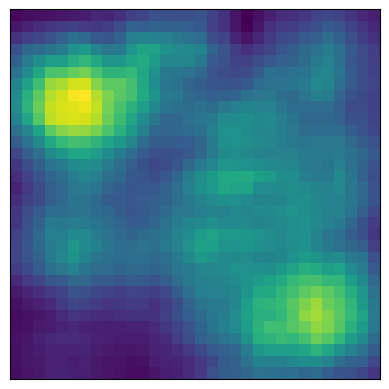

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure with a single subplot
fig, ax = plt.subplots()

ax.imshow(new_image)
# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
# Show the plot
plt.show()